<a href="https://colab.research.google.com/github/amirgarsha/deeplearning_course/blob/main/cnn_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [1]:
!nvidia-smi

Thu Dec 29 07:18:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Install**

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 10.3 MB/s 


# **Imports 📢**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms as T
from torchvision.datasets import CIFAR10

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Transform

In [17]:
transform_train = T.Compose([T.ToTensor(),T.Normalize(mean=(0.4914,0.4822, 0.4465),\
                                                      std=(0.2023,0.1994,0.2010))])

## CIFAR Dataset

In [18]:
## load dataset and transform it to tensor
train_set = CIFAR10(root='./cifar10', train=True, download=True, transform = transform_train )
test_set = CIFAR10(root='./cifar10', train=False, download=True , transform = transform_train)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
## just for calculating mean dataset **could be ignored**
print(torch.FloatTensor(train_set.data/255.).mean(dim=[0,1,2]))
print(torch.FloatTensor(test_set.data/255.).mean(dim=[0,1,2]))

tensor([0.4914, 0.4822, 0.4465])
tensor([0.4942, 0.4851, 0.4504])


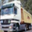

In [14]:
##show image in dataset (before transform)
## after transformation this cell do not show image
train_set[1][0]

In [22]:
## show image in dataset (after transform)
train_set[1][0]

tensor([[[ 0.5562,  0.0134, -0.3936,  ..., -0.6650, -0.7426, -0.8977],
         [ 0.2848,  0.3817, -0.0060,  ..., -0.5681, -0.9364, -1.0527],
         [ 0.2848,  0.2654, -0.1998,  ..., -0.8977, -1.1109, -1.1303],
         ...,
         [ 0.9633,  0.5950,  0.5562,  ..., -1.6149, -1.2466, -0.6263],
         [ 0.7694,  0.5950,  0.6531,  ..., -0.4324, -0.0447,  0.1104],
         [ 0.7307,  0.6338,  0.7307,  ...,  0.3430,  0.3430,  0.3430]],

        [[ 1.0628,  0.2761, -0.3729,  ..., -0.5499, -0.6482, -0.8252],
         [ 0.7284,  0.5908,  0.0401,  ..., -0.4712, -0.8449, -0.9826],
         [ 0.6301,  0.4531, -0.1566,  ..., -0.8056, -1.0416, -1.0612],
         ...,
         [ 0.8661,  0.6104,  0.7284,  ..., -1.7496, -1.3759, -0.7859],
         [ 0.6104,  0.5711,  0.7481,  ..., -0.5892, -0.1762, -0.0386],
         [ 0.4924,  0.4924,  0.6498,  ...,  0.1974,  0.2171,  0.1974]],

        [[ 1.4270,  0.4320, -0.3679,  ..., -0.8362, -0.8362, -0.8557],
         [ 1.0758,  0.7832,  0.0808,  ..., -0

In [19]:
train_set[10][0].shape

torch.Size([3, 32, 32])

In [20]:
## show classes in dataset
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [21]:
## show index of classes
train_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## DataLoader

In [26]:
train_loader = DataLoader(train_set, batch_size = 64 , shuffle = True)
test_loader = DataLoader(train_set, batch_size = 128 , shuffle = True)

In [27]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([8, 9, 2, 0, 3, 7, 6, 4, 7, 1, 2, 6, 3, 1, 8, 8, 4, 2, 6, 6, 1, 4, 1, 0,
        1, 4, 3, 0, 4, 0, 5, 3, 7, 0, 4, 8, 7, 0, 0, 7, 2, 0, 8, 5, 0, 7, 0, 2,
        7, 1, 2, 9, 7, 5, 7, 5, 9, 4, 1, 6, 8, 8, 1, 6])


## Visualize

In [28]:
## code just copied / just for visulaizing

def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)
    
    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

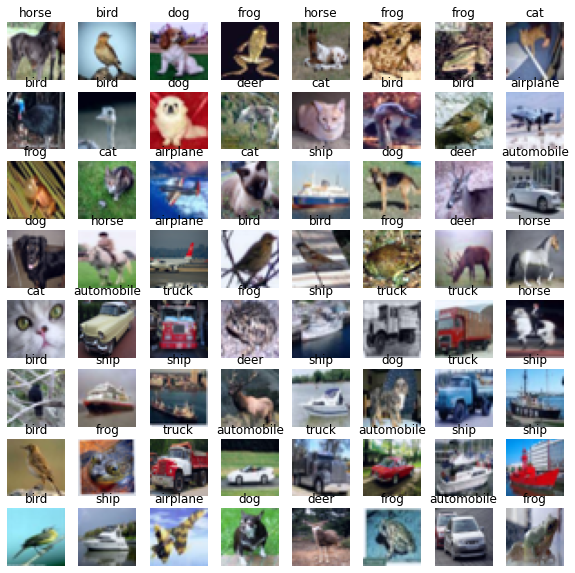

In [29]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [ ]:
num_params(model)

# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [ ]:
device

# **Loss & Optimizer ⚖️**

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

## Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

## Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 2
for lr in [0.1, 0.01]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN().to(device)   
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

## Step 5: train more epochs

In [ ]:
model = CNN().to(device)

In [ ]:
lr = 0.05
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

# **Plot**

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()